# Анализ и результаты тестирования на IAM

In [1]:
import albumentations as A
import copy
import cv2
import Levenshtein
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import random
import seaborn as sns

from collections import Counter

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Посмотрим сначала на распределение символов в обучающем и тестовом датасетах:

In [2]:
def show_dir_info(input_dir):
    filenames = os.listdir(path=input_dir)
    dict_set = set()
    max_len = 0
    char_counter = Counter()
    for filename in filenames:
        label = filename.split('_')[0]
        dict_set = dict_set | set(label)
        max_len = max(max_len, len(label))
        char_counter = char_counter + Counter(label)
    dict_list = list(dict_set)
    print('Word number: {}'.format(len(filenames)))
    print('Max word length: ' + str(max_len))
    print('Alphabet size: ' + str(len(dict_list)))
    print('Dictionary: ' + ''.join(sorted(dict_list)))
    
    sorted_dict = sorted(dict(char_counter).items(), key=lambda kv: kv[1])
    keys = list(s[0] for s in sorted_dict)
    values = list(s[1] for s in sorted_dict)

    plt.figure(figsize=(12, 20))
    g = sns.barplot(y=keys, x=values)
    for i, value in enumerate(values):
        g.text(value, i, value, color='black', va='center')
    plt.title('Количество каждого символа в обучающем датасете')
    plt.xlabel('Количество в датасете')
    plt.ylabel('Символ')
    plt.show()

##### Обучающий датасет:

Word number: 60766
Max word length: 21
Alphabet size: 65
Dictionary: '-.0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


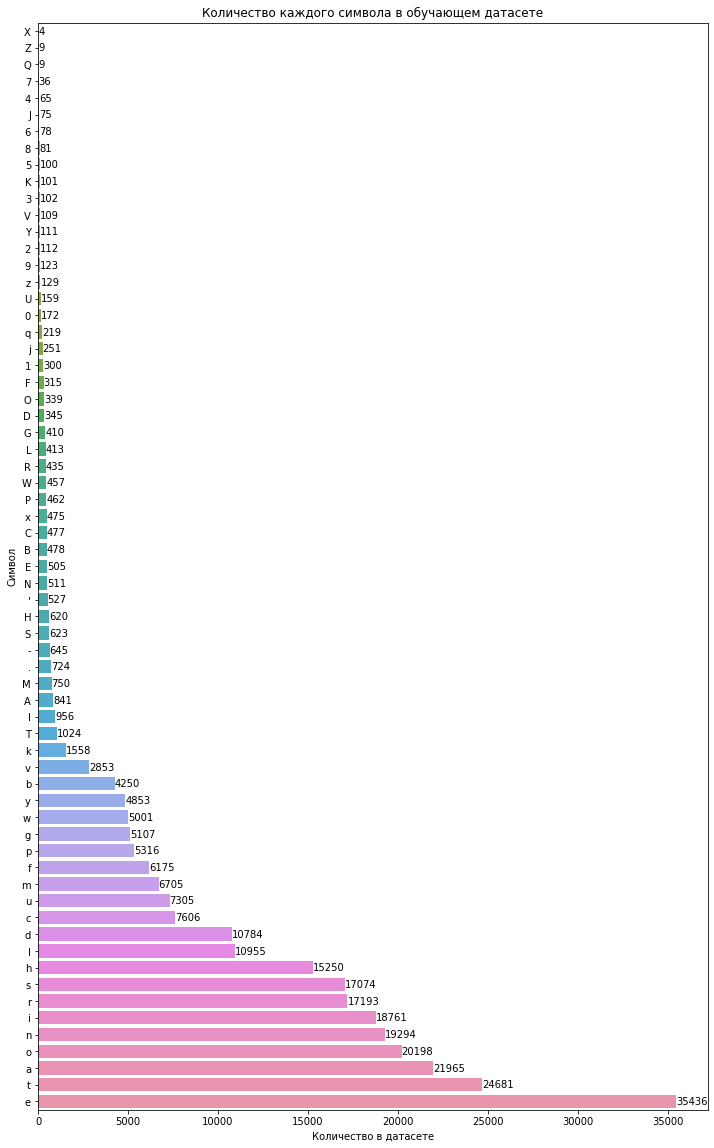

In [3]:
show_dir_info('/home/astrashnov/data/rec/iam_data/train_words')

##### Тестовый датасет:

Word number: 17755
Max word length: 21
Alphabet size: 63
Dictionary: '-.0123456789ABCDEFGHIJKLMNOPQRSTUVWYabcdefghijklmnopqrstuvwxyz


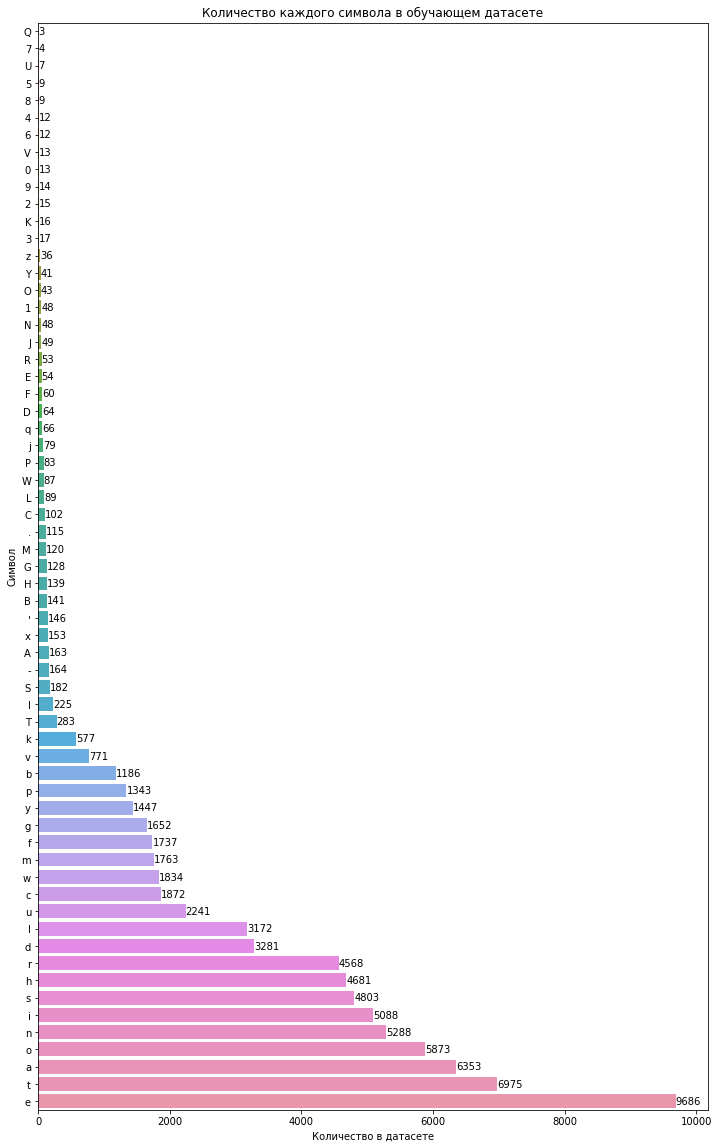

In [4]:
show_dir_info('/home/astrashnov/data/rec/iam_data/test_words')

Видно, что распределения символов в обучающем и тестовом датасетах похожи.

Посмотрим теперь на некотрые изображения из обучающего датасета:

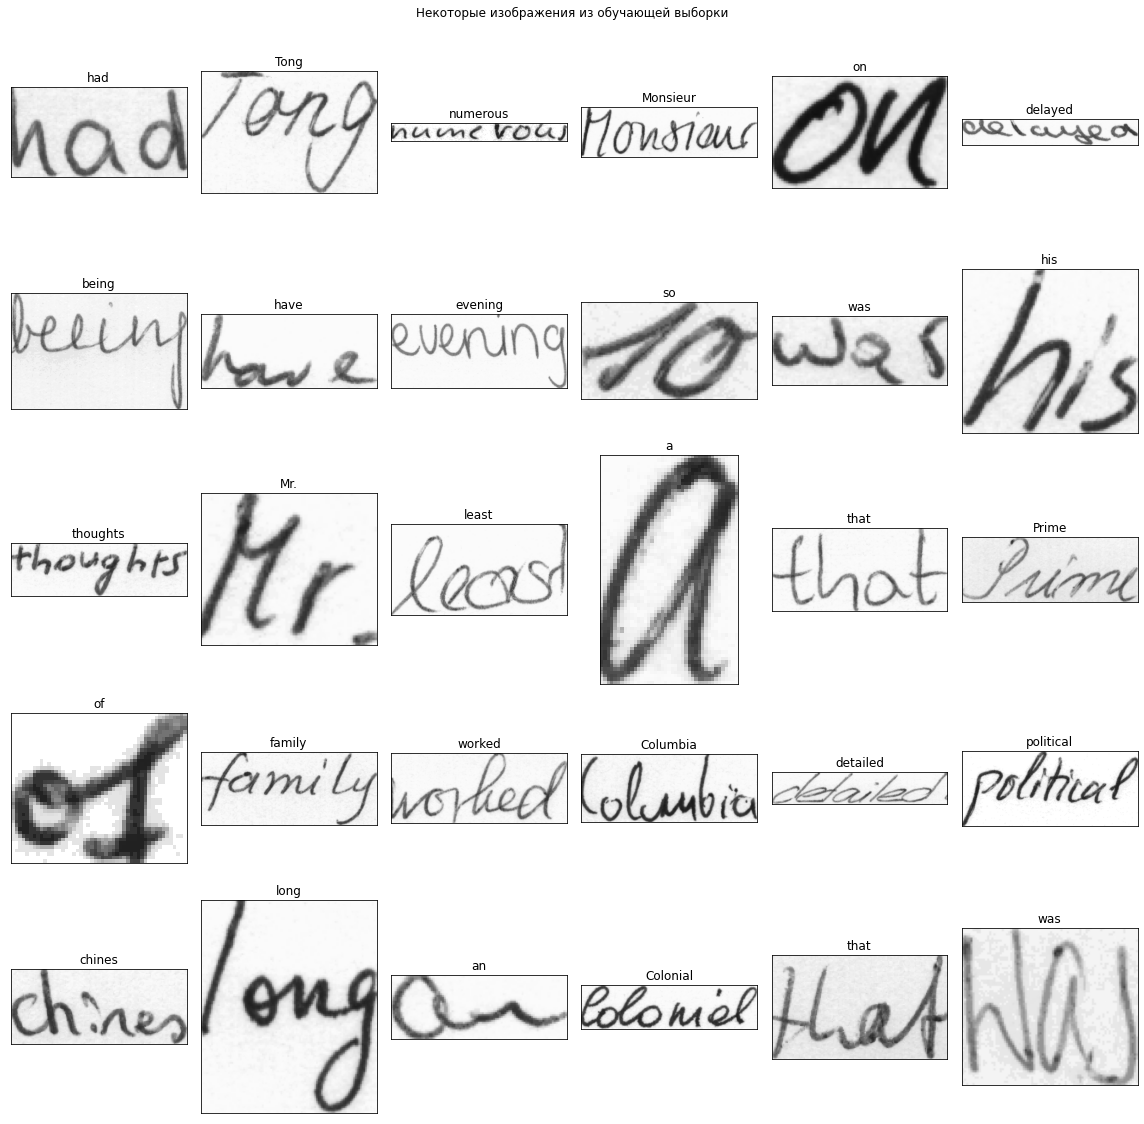

In [5]:
train_dir = '/home/astrashnov/data/rec/iam_data/train_words'
imgs = os.listdir(train_dir)
imgs = random.choices(imgs, k=30)

plt.figure(figsize=(16, 16))
for i, img in enumerate(imgs):
    label = img.split('_')[0]
    image = cv2.imread(os.path.join(train_dir, img))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Некоторые изображения из обучающей выборки')
plt.tight_layout()
plt.show()

Получим предсказания обученной модели, а также правильные метки:

In [6]:
pred_file = '/home/astrashnov/PaddleOCR/output/rec/predicts_srn_original_LC_UC_Num_Pc3.txt'
target_file = '/home/astrashnov/data/rec/iam_data/rec_test.txt'

In [7]:
def get_dict(filename):
    with open(filename) as f:
        lines = f.readlines()
    word_dict = {}
    for line in lines:
        l = line.strip('\n')
        if len(l) == 0:
            continue
        img_path, label = l.split('\t')[:2]
        word_dict[pathlib.PurePath(img_path).name] = label
    return word_dict

In [8]:
def general_stat(predictions_file, target_file, long_word_min_len=10):
    pred_dict = get_dict(predictions_file)
    target_dict = get_dict(target_file)

    cases = ('LC + UC, all words', 'LC + UC, long words', 'MC, all words', 'MC, long words')
    correct_num = {case: 0 for case in cases}
    edit_dis = {case: 0.0 for case in cases}
    norm_edit_dis = {case: 0.0 for case in cases}
    long_num = 0
    all_num = 0
    long_char = 0
    all_char = 0

    for name, target in target_dict.items():
        pred = pred_dict[name]
        pred_target = {'LC + UC': (pred, target), 'MC': (pred.lower(), target.lower())}

        is_long = (len(target) >= long_word_min_len)

        for case, (pred, target) in pred_target.items():
            cur_edit_dis = Levenshtein.distance(pred, target)
            is_correct = int(pred == target)

            correct_num[case + ', all words'] += is_correct
            edit_dis[case + ', all words'] += cur_edit_dis
            norm_edit_dis[case + ', all words'] += cur_edit_dis / len(target)

            if is_long:
                correct_num[case + ', long words'] += is_correct
                edit_dis[case + ', long words'] += cur_edit_dis
                norm_edit_dis[case + ', long words'] += cur_edit_dis / len(target)

        all_char += len(target)
        all_num += 1

        if is_long:
            long_char += len(target)
            long_num += 1

    acc = {'Accuracy ({})'.format(case): 1.0 * correct_num / max(all_num if (case[-9:-6] == 'all') else long_num, 1)
            for case, correct_num in correct_num.items()}
    norm_edit_dis = {'Normalized edit distance 1 ({})'.format(case): dis / max(all_num if (case[-9:-6] == 'all') else long_num, 1)
            for case, dis in norm_edit_dis.items()}
    edit_dis = {'Normalized edit distance 2 ({})'.format(case): dis / max(all_char if (case[-9:-6] == 'all') else long_char, 1)
            for case, dis in edit_dis.items()}
    quality_dict = dict(**acc, **norm_edit_dis, **edit_dis)

    for key, value in quality_dict.items():
        print(f'{key}: {value}')

In [9]:
def detailed_stat(predictions_file, target_file, long_word_min_len=10):
    pred_dict = get_dict(predictions_file)
    target_dict = get_dict(target_file)

    alphabet = "'-.0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
    cases = ('LC + UC, all words', 'LC + UC, long words', 'MC, all words', 'MC, long words')
    matrix1 = {'del': {char: 0 for char in alphabet}, 'ins': {char: 0 for char in alphabet}}
    matrix1 = dict(**matrix1, **{sym: {char: 0 for char in alphabet} for sym in alphabet})
    matrix2 = {'del': {char: 0 for char in alphabet[:-26]}, 'ins': {char: 0 for char in alphabet[:-26]}}
    matrix2 = dict(**matrix2, **{sym: {char: 0 for char in alphabet[:-26]} for sym in alphabet[:-26]})
    matrices = {case: copy.deepcopy(matrix1) if case[0] == 'L' else copy.deepcopy(matrix2) for case in cases}
    
    mistakes = []
    for name, target in target_dict.items():
        pred = pred_dict[name]
        pred_target = {'LC + UC': (pred, target), 'MC': (pred.lower(), target.lower())}
        
        if target != pred:
            mistakes.append((pred, target, name))

        is_long = (len(target) >= long_word_min_len)

        for case, (pred, target) in pred_target.items():
            ops = Levenshtein.editops(pred, target)
            matrices_names = [case + ', all words',]
            if is_long:
                matrices_names.append(case + ', long words')
            for matrix_name in matrices_names:
                for op in ops:
                    if op[0] == 'insert':
                        matrices[matrix_name]['ins'][target[op[2]]] += 1
                    elif op[0] == 'delete':
                        matrices[matrix_name]['del'][pred[op[1]]] += 1
                    elif op[0] == 'replace':
                        matrices[matrix_name][pred[op[1]]][target[op[2]]] += 1
                        
    tables = {}
    for case in cases:
        tables[case] = pd.DataFrame.from_dict(matrices[case]).transpose()
        
    return tables, mistakes

##### Качество модели:

In [10]:
general_stat(pred_file, target_file)

Accuracy (LC + UC, all words): 0.8217966769923966
Accuracy (LC + UC, long words): 0.5612535612535613
Accuracy (MC, all words): 0.8339059419881724
Accuracy (MC, long words): 0.5712250712250713
Normalized edit distance 1 (LC + UC, all words): 0.06386012299241943
Normalized edit distance 1 (LC + UC, long words): 0.0854118273191269
Normalized edit distance 1 (MC, all words): 0.05875323458998067
Normalized edit distance 1 (MC, long words): 0.08298199812647719
Normalized edit distance 2 (LC + UC, all words): 0.07009180790960452
Normalized edit distance 2 (LC + UC, long words): 0.0874983772556147
Normalized edit distance 2 (MC, all words): 0.06589235270379339
Normalized edit distance 2 (MC, long words): 0.08503180578995197


In [11]:
tables, mistakes = detailed_stat(pred_file, target_file)

Посмотрим на посимвольные таблицы ошибок для разных длин слов с учётом и без учёта регистра:

In [12]:
tables['LC + UC, all words']

,',-,.,0,1,2,3,4,5,6,7,8,9,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z
del,2,0,3,0,0,0,0,0,0,0,0,0,0,48,4,48,12,89,9,14,22,26,1,4,38,11,38,67,17,2,58,68,50,42,2,7,0,13,0,2,1,0,2,0,1,1,1,2,0,0,0,0,0,1,2,1,0,6,4,0,0,0,0,0,0
ins,4,3,3,0,1,0,1,0,0,0,0,0,0,18,3,31,10,52,10,3,22,25,0,3,36,4,26,27,4,0,66,61,57,22,2,6,1,7,1,2,0,1,1,0,0,1,0,4,2,0,1,0,0,1,2,0,0,2,4,0,0,0,0,0,0
',0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
.,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
tables['MC, all words']

,',-,.,0,1,2,3,4,5,6,7,8,9,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
del,2,0,3,0,0,0,0,0,0,0,0,0,0,50,5,48,14,90,11,15,23,28,1,4,38,11,38,68,19,3,59,72,53,42,2,7,0,13,0
ins,4,3,3,0,1,0,1,0,0,0,0,0,0,19,2,33,11,53,9,4,22,31,1,3,37,4,26,26,5,0,66,63,61,24,3,6,1,7,1
',0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
-,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
.,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,2,0,0,0,1,0,0,0
0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0


In [14]:
tables['LC + UC, long words']

,',-,.,0,1,2,3,4,5,6,7,8,9,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z
del,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,5,1,6,0,2,1,4,0,1,3,0,4,8,7,0,4,8,9,2,1,0,0,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ins,2,1,0,0,0,0,0,0,0,0,0,0,0,3,1,6,1,14,0,0,6,5,0,0,5,0,10,4,0,0,9,10,5,4,0,1,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
',0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
tables['MC, long words']

,',-,.,0,1,2,3,4,5,6,7,8,9,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
del,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,5,1,6,0,2,1,4,0,1,3,0,4,8,7,0,4,8,9,2,1,0,0,4,0
ins,2,1,0,0,0,0,0,0,0,0,0,0,0,3,1,7,1,14,0,0,6,5,0,0,5,0,10,4,0,0,9,9,5,4,0,1,0,2,1
',0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Посмотрим на некоторые неправильно распознанные изображения:

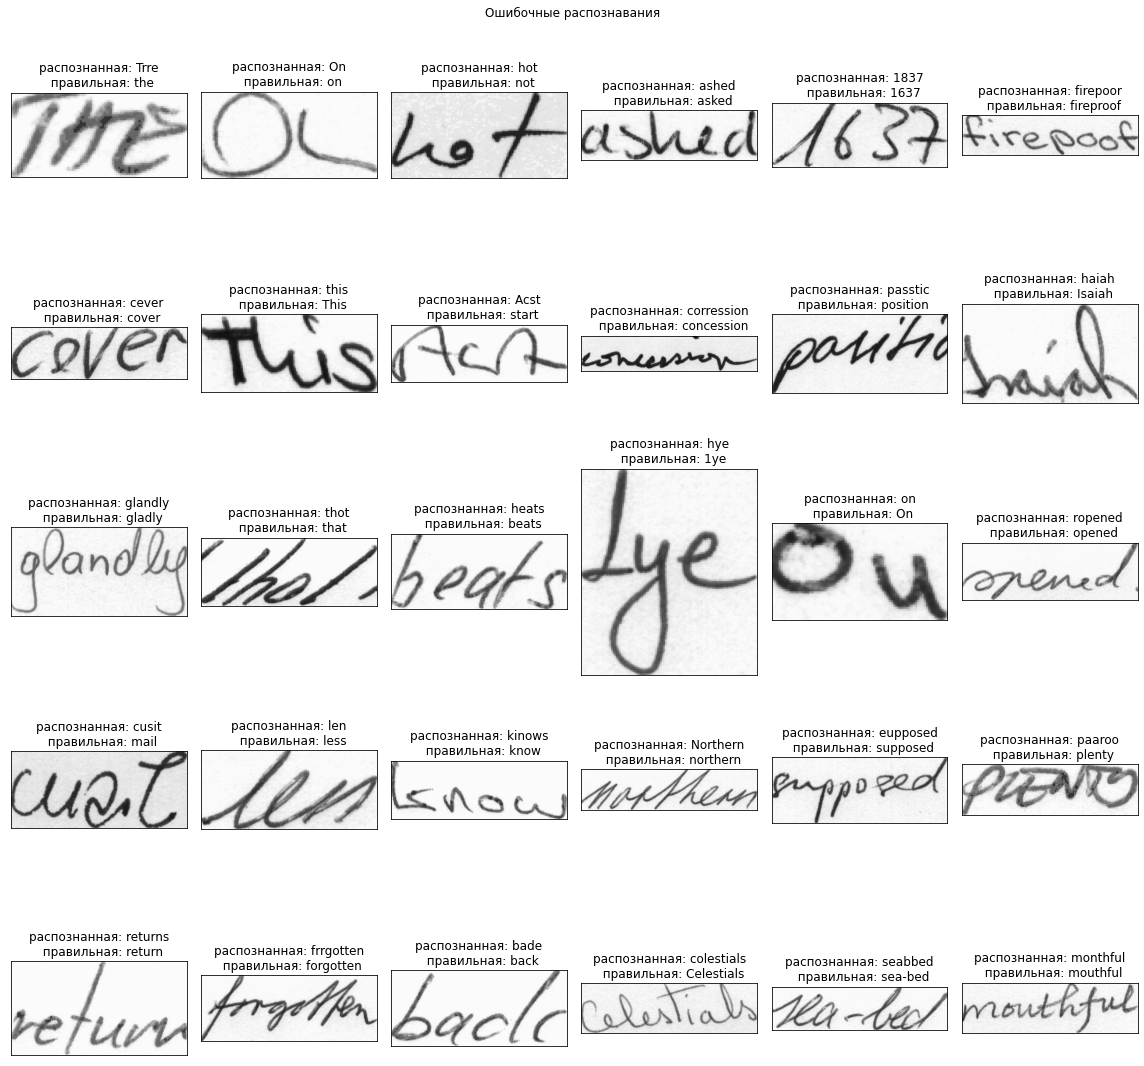

In [16]:
test_dir = '/home/astrashnov/data/rec/iam_data/test_words'
some_mistakes = random.choices(mistakes, k = 30)

plt.figure(figsize=(16, 16))
for i, (pred, target, name) in enumerate(some_mistakes):
    image = cv2.imread(os.path.join(test_dir, name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(f'распознанная: {pred}\n  правильная: {target}')
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Ошибочные распознавания')
plt.tight_layout()
plt.show()

Видно, что большая часть ошибок - пропущенные или лишние символы в слове. Объяснение этому даётся в статье про SRN: если на этапе нахождения визуального контекста модель неправильно определила количество символов, она уже не может исправить это на этапе учёта семантического контекста.